## El objetivo de este ejercicio es calcular la función de valor de una política dada usando sampleo Monte Carlo.
<img src="Prediccion_MC.PNG">

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Algoritmo de predicción Monte Carlo "primera-visita". Calcula la función de valor para una 
    politica dada usando sampleo.
    
    Argumentos:
        policy: Política, función que mapea observaciones a probabilidades de cada acción.
        env: Ambiente de OpenAI gyn.
        num_episodes: Número de episodios a samplear.
        discount_factor: factor de descuento gama.
    
    Retorna:
        Un diccionario que mapea estado -> valor.
        El estado es una tupla y el valor es un float.
    """  
    # Mantiene una suma y conteo de los retornos de cada estado
    # para calcular un promedio. Podría usarse un array para guardar todos los retornos
    # pero sería ineficiente en memoria.
    # CUIDADO: las llaves de un diccionario deben ser inmutables, por ejemplo tuples
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # El valor final de la función de valor
    V = defaultdict(float)
    
    # loop num_episodes veces
    for i_episode in range(1, num_episodes + 1):
        # printear el número de episodio cada mil episodios, para saber donde estamos
        if i_episode % 1000 == 0:
            print("\rEpisodio {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # generar un episodio de máximo 100 pasos
        # un episodio es una lista de tuplas (estado, accion, recompensa)
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # con el episodio generado: 
        # iterar sobre los estados visitados en este episodio, 
        # TIP 1: podemos usar set() para obtener estados unicos
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # por cada estado encontrar su primera aparición en el episodio (estamos implementando "primera-visita")
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # obtener el retorno a partir de ese momento
            # TIP 2: es posible iterar sobre los indices y valores devueltos por enumerate(lista) 
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calcular el retorno medio para este estado utilizando los episodios sampleados
            returns_sum[state] += G
            returns_count[state] += 1.0
            # podemos usar la formula de la media usual:
            #V[state] = returns_sum[state] / returns_count[state]
            # o usar la formula para la media incremental:
            V[state] = V[state] + 1/returns_count[state] * (G - V[state])

    return V    

In [4]:
def sample_policy(observation):
    """
    Una política que se planta si el jugador tiene un puntaje >= 20 y pide otra carta caso contrario.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episodio 10000/10000.

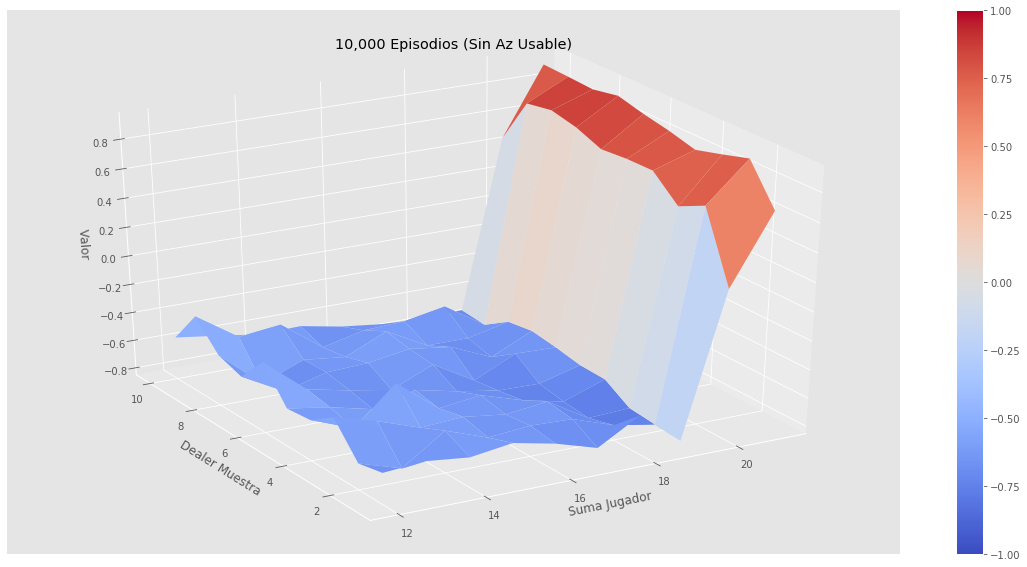

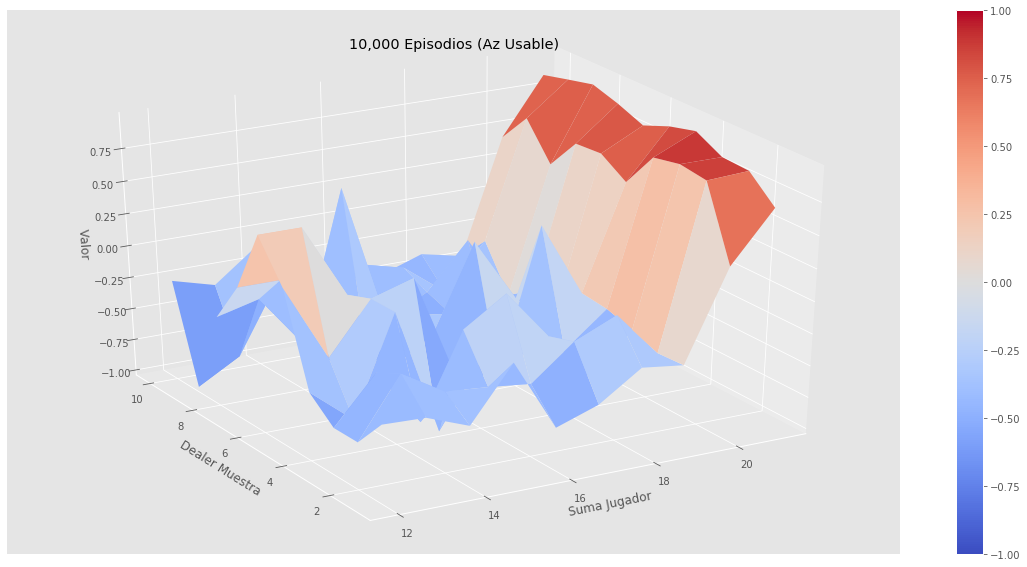

Episodio 500000/500000.

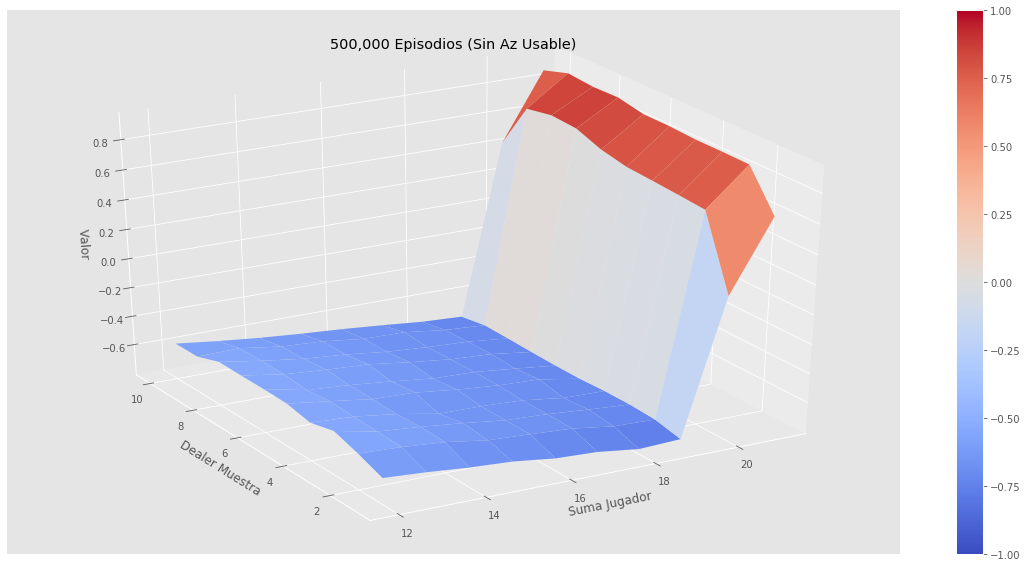

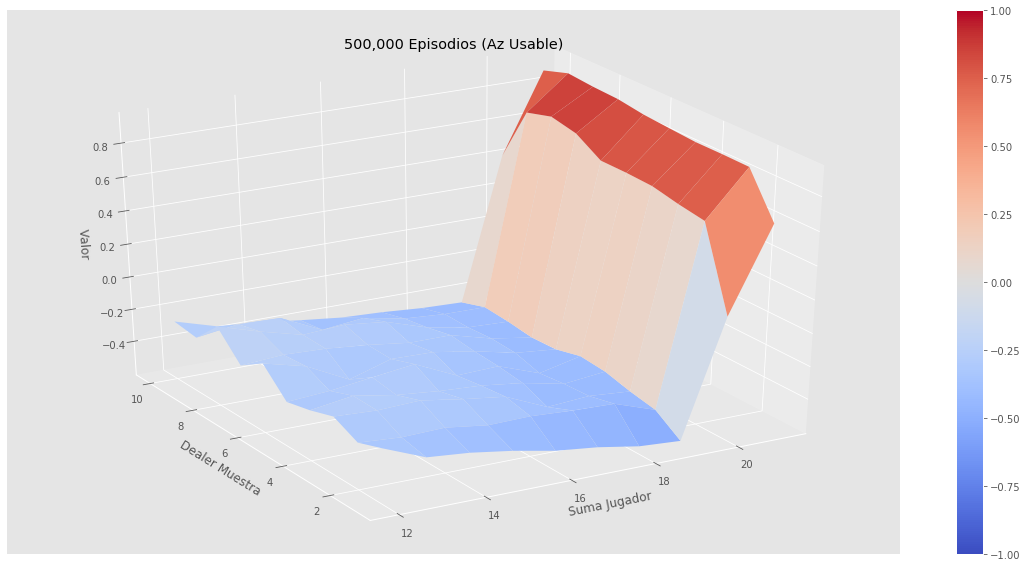

In [5]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Episodios")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Episodios")